# Import

In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import *
import itertools

import os

import xgboost as xgb 
from xgboost import plot_importance , XGBClassifier

import lightgbm as lgbm
from lightgbm import LGBMClassifier

from keras.utils.np_utils import to_categorical 
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *

# Read Data

In [2]:
train = pd.read_csv('./open data/train.csv')
test = pd.read_csv('./open data/test_x.csv')
train_copy = train.copy()
test_copy = test.copy()

FileNotFoundError: [Errno 2] No such file or directory: './open data/train.csv'

# Data Cleaning

Q_E (a~t), familysize : outlier => binning?

education, engnat, hand, married, urban : NaN (=0)

# Two ways of data cleaning:

without NaN : fill in the data with appropriate way
e.g.) KNN, correlation heatmap

with NaN : consider 0 as new answer

In [3]:
def drop_outlier(data):
    outlier_id = np.where(data['familysize']>=100)[0]
    pdata = data.drop(outlier_id)
    
    return pdata

In [4]:
def drop_feature(data):
    feature_arr = ['index','urban']
    """for i in range(20):
        featrue_arr.append('Q'+chr(i+97)+'E')"""
    for i in range(1,14):
        feature_arr.append(f'wr_{i:02d}')
    for i in range(1,4):
        feature_arr.append(f'wf_{i:02d}')
    pdata = data.drop(feature_arr,axis=1)
    
    return pdata

In [5]:
def age_band(data):
    pdata = data.copy()
    pdata['age_group'].replace(['10s','20s','30s','40s','50s','60s','+70s'],[1,2,3,4,5,5,5],inplace=True)
    
    return pdata

In [6]:
def cat_gender(data):
    feature = 'gender'
    pdata = data.copy()
    pdata[feature].replace(['Male','Female'],[0,1],inplace=True)
    
    return pdata

In [7]:
def cat_race(data):
    feature = 'race'
    pdata = data.copy()
    unique = ['White', 'Asian', 'Other', 'Black', 'Native American', 'Arab', 'Indigenous Australian']
    pdata[feature].replace(unique,[0,1,2,2,2,2,2],inplace=True)
    
    return pdata

In [8]:
def cat_religion(data):
    feature = 'religion'
    pdata = data.copy()
    unique = ['Other', 'Hindu', 'Agnostic', 'Atheist', 'Christian_Other',
       'Christian_Catholic', 'Muslim', 'Buddhist', 'Christian_Protestant',
       'Jewish', 'Christian_Mormon', 'Sikh']
    pdata[feature].replace(unique,[3,3,1,0,2,2,3,3,2,3,3,3],inplace=True)
    
    return pdata

In [9]:
def cat_num(data):
    pdata = data.copy()
    pdata = cat_gender(pdata)
    pdata = cat_race(pdata)
    pdata = cat_religion(pdata)
    
    return pdata

Q_E bands : 
- num_bands
- log?

In [10]:
def E_band(data, num_band):
    pdata = data.copy()
    for i in range(20):
        col = 'Q'+chr(i+97)+'E'
        pdata[col] = pd.qcut(pdata[col],num_band)
        unique = pdata[col].unique()
        pdata[col].replace(unique,range(num_band),inplace=True)
        
    return pdata

In [11]:
def family_band(data):
    pdata = data.copy()
    f_id = np.where(pdata['familysize']>=4)[0]
    for i in f_id:
        pdata.iloc[i,43]=4
    
    return pdata

In [12]:
def fill_married(data):
    pdata = data.copy()
    index = np.where(pdata['married']==0)[0]
    for i in index:
        if (pdata['age_group'][i]=='10s') or (pdata['age_group'][i]=='20s'):
            pdata.iloc[i,47] = 1
        else :
            pdata.iloc[i,47] = 2
    
    return pdata

In [13]:
def fill_education(data):
    pdata = data.copy()
    index = np.where(pdata['education']==0)[0]
    for i in index:
        if (pdata['age_group'][i]=='10s') :
            pdata.iloc[i,42] = 2
        else :
            pdata.iloc[i,42] = 3
    
    return pdata

In [14]:
def fill_engnat(data):
    pdata = data.copy()
    index = np.where(pdata['engnat']==0)[0]
    for i in index:
        pdata.iloc[i,43]
    
    return pdata

In [15]:
def preprocess(data):
    
    pdata = data.copy()
    pdata = drop_feature(pdata)
    pdata = fill_married(pdata)
    pdata = fill_education(pdata)
    pdata = fill_engnat(pdata)
    pdata = age_band(pdata)
    pdata = family_band(pdata)
    pdata = cat_num(pdata)
    pdata = E_band(pdata,10)
    pdata = pdata.astype(np.int)
    
    return pdata

In [16]:
train_x = drop_outlier(train_copy)
train_x = preprocess(train_x)
train_y = train_x['voted']
train_x = train_x.drop(['voted'],axis=1)
train_t = pd.concat([train_x,train_y],axis=1)

test_p = preprocess(test_copy)

# wr_ & wf_ = confidence score? 

# Q_A  to  Machiavelli score

# EDA

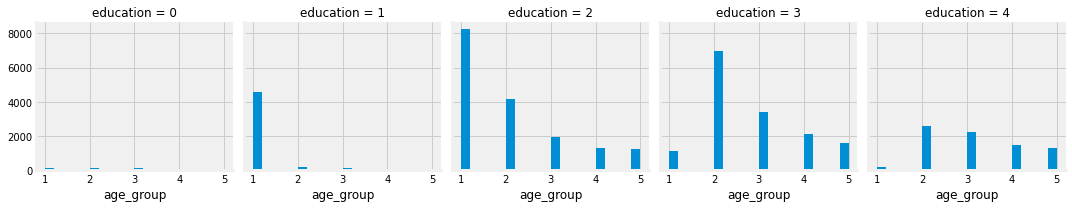

In [17]:
g = sns.FacetGrid(train_t,col='education',sharex=False)
g.map(plt.hist, 'age_group', bins=20)

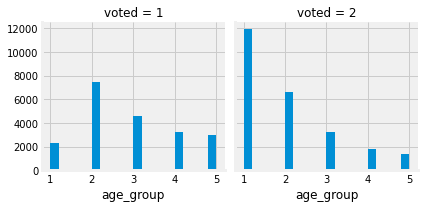

In [18]:
g = sns.FacetGrid(train_t,col='voted',sharex=False)
g.map(plt.hist, 'age_group', bins=20)

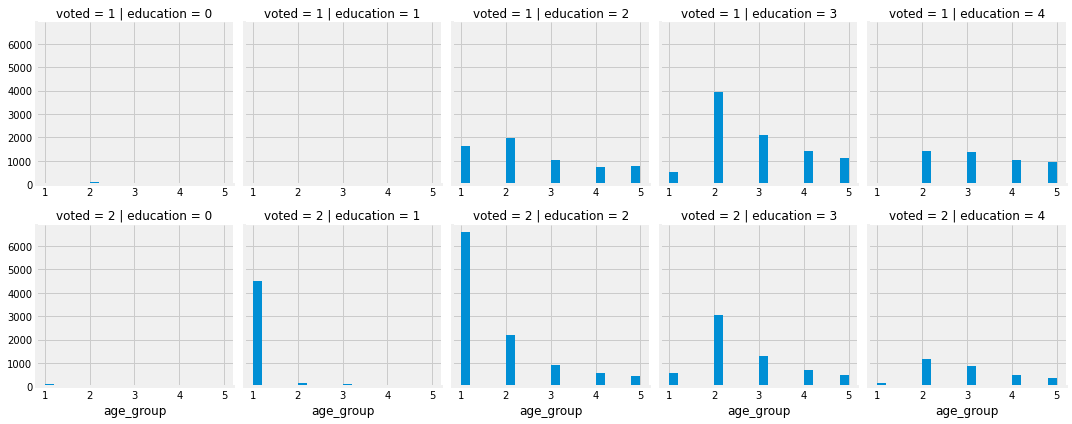

In [19]:
g = sns.FacetGrid(train_t,col='education', row='voted', sharex=False)
g.map(plt.hist, 'age_group', bins=20)

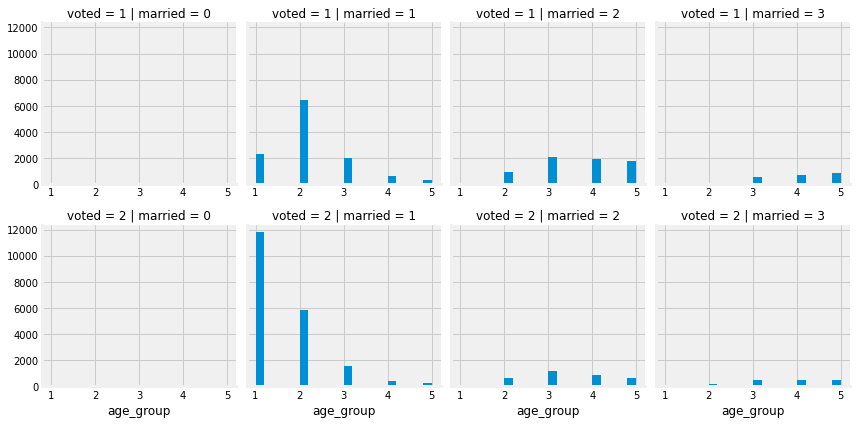

In [20]:
g = sns.FacetGrid(train_t,col='married', row='voted', sharex=False)
g.map(plt.hist, 'age_group', bins=20)

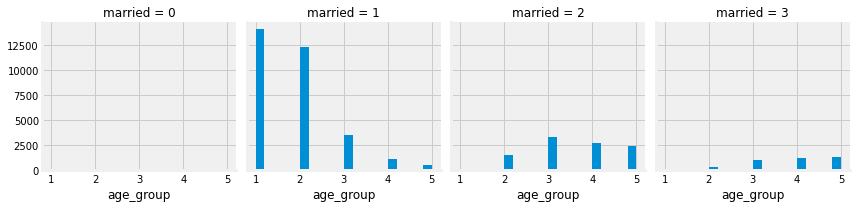

In [21]:
g = sns.FacetGrid(train_t,col='married',sharex=False)
g.map(plt.hist, 'age_group', bins=20)

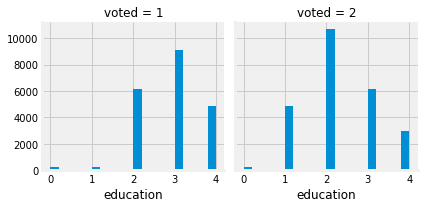

In [22]:
g = sns.FacetGrid(train_t,col='voted',sharex=False)
g.map(plt.hist, 'education', bins=20)

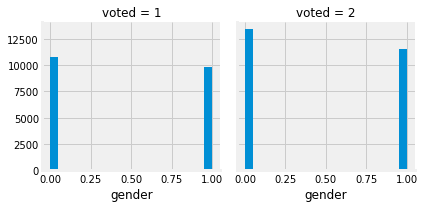

In [23]:
g = sns.FacetGrid(train_t,col='voted', sharex=False)
g.map(plt.hist, 'gender', bins=20)

# age_group = 10s 

- mostly did not vote
- 10s & education=1 almost did not vote

# education = 1

- almost did not vote

# married = 2

- may have voted

# 'urban' feature may be dropped?

In [24]:
train_copy[['age_group','voted']].groupby(['age_group'],as_index=False).mean().sort_values(by='voted',ascending=False)

,age_group,voted
1,10s,1.837214
2,20s,1.469671
3,30s,1.411179
4,40s,1.357949
5,50s,1.329872
6,60s,1.271357
0,+70s,1.263830


In [26]:
feature = 'engnat'
train_copy[[feature,'voted']].groupby([feature],as_index=False).agg(['mean','size']).sort_values(by=('voted', 'mean'),ascending=False)

voted       
            mean   size
engnat                 
0       1.623377     77
2       1.571394  12431
1       1.537397  33024

In [27]:
feature = 'education'
train_copy[[feature,'voted']].groupby([feature],as_index=False).agg(['mean','size']).sort_values(by=('voted', 'mean'),ascending=False)

voted       
               mean   size
education                 
1          1.950275   5088
2          1.632967  16835
0          1.522727    528
3          1.403494  15227
4          1.380316   7854

In [28]:
feature = 'race'
train_copy[[feature,'voted']].groupby([feature],as_index=False).agg(['mean','size']).sort_values(by=('voted', 'mean'),ascending=False)

voted       
                           mean   size
race                                  
Arab                   1.709402    351
Asian                  1.704565   6834
Other                  1.622402   4330
Black                  1.597786   2168
Native American        1.587591    548
Indigenous Australian  1.547170     53
White                  1.495776  31248

In [29]:
feature = 'religion'
train_copy[[feature,'voted']].groupby([feature],as_index=False).agg(['mean','size']).sort_values(by=('voted', 'mean'),ascending=False)

voted       
                          mean   size
religion                             
Muslim                1.687081   1192
Sikh                  1.641026    117
Buddhist              1.621176    850
Christian_Mormon      1.619159    428
Hindu                 1.613016   1429
Other                 1.582809   4770
Atheist               1.572704  10192
Agnostic              1.542602   9624
Christian_Other       1.539615   5137
Christian_Catholic    1.526512   6431
Jewish                1.449692    487
Christian_Protestant  1.434667   4875

In [30]:
def plot_heatmap(data,feature):
    fig, ax = plt.subplots(figsize=(15,15))
    corr = data.corr()
    cols_s = corr.nsmallest(5,feature)[feature].index
    cols_l = corr.nlargest(6,feature)[feature].index
    cols = cols_l.append([cols_s])
    cm = np.corrcoef(train_t[cols].values.T)
    sns.set(font_scale=1.25)
    sns.heatmap(cm,cbar=True,annot=True, square=True, fmt='.2f', annot_kws={"size":10}, yticklabels=cols.values,xticklabels=cols.values,cmap='Blues', ax=ax)
    
    return cols

Index(['married', 'age_group', 'education', 'tp02', 'QqA', 'QkA', 'voted',
       'QoA', 'QsA', 'QtA', 'QpA'],
      dtype='object')

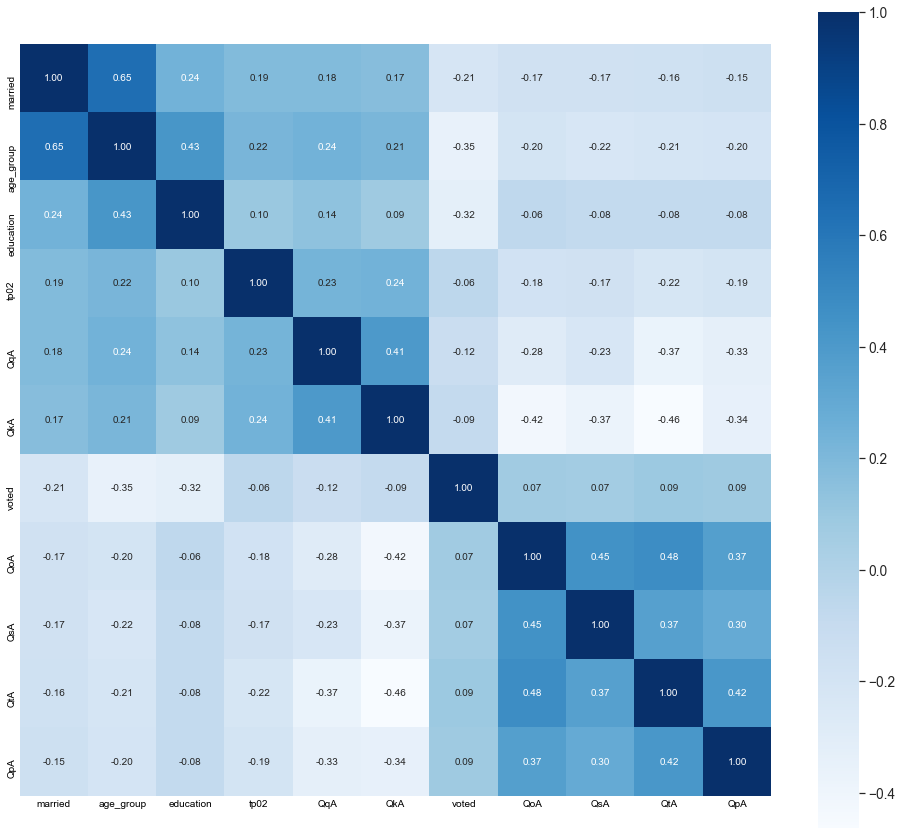

In [31]:
plot_heatmap(train_t,'married')

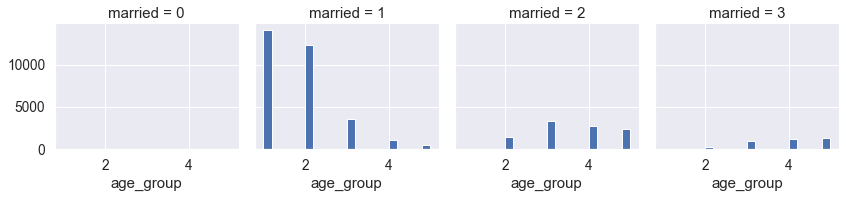

In [32]:
g = sns.FacetGrid(train_t,col='married',sharex=False)
g.map(plt.hist, 'age_group', bins=20)

In [33]:
train_t['age_group'].describe()

count    45529.000000
mean         2.366272
std          1.283470
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max          5.000000
Name: age_group, dtype: float64

In [34]:
a = train_copy[train_copy['married']==0][['index','education','age_group','married']]
a['age_group'].value_counts()

10s    40
20s    19
40s    16
30s    10
50s     4
60s     4
Name: age_group, dtype: int64

In [35]:
a[(a['age_group']=='30s')]

,index,education,age_group,married
4007,4007,2,30s,0
4235,4235,4,30s,0
5373,5373,2,30s,0
11270,11270,4,30s,0
23106,23106,3,30s,0
27840,27840,4,30s,0
31092,31092,2,30s,0
33372,33372,3,30s,0
38500,38500,3,30s,0
44125,44125,2,30s,0
